In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from sksurv.metrics import concordance_index_censored
import numpy as np
import scipy.stats
from functools import partial
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator


def mean_confidence_interval(data, confidence=0.95):
    """ Calculate mean, lower and upper bound of confidence interval """
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def Dxy(e,y,x):
    """ Calculate Dxy """
    return 2 * concordance_index_censored(e, y, x)[0] - 1


def bootstrap_dxy(df, n=5):
    """ Boostrap and calculate Dxy """
    e, y, x = df.columns
    #print(df.columns)
    result = []

    # resample n times
    for i in range(n):
        sample = df.sample(df.shape[0], replace=True)
        #print(sample)
        # calculate Dxy
        result.append(Dxy(sample[e], sample[y], sample[x]))
    return result

def apply_stats_for_each_value(df, fmap, condition_names=None):
    """ Apply stats to each value in column """

    all_count = df.shape[0]
    
    dff = pd.DataFrame({'E':df['E'], 'Y':df['Y'], 'agg':df.apply(fmap, axis=1)}).dropna()
    selected_count = dff.shape[0]
    
    stats = dff['Y'].aggregate(['count', 'median'])
    
    dxy_bootstraped = bootstrap_dxy(dff[['E', 'Y', 'agg']])
    # confidence interval
    dxy, ci_low, ci_high =  mean_confidence_interval(dxy_bootstraped)
    
    ret = {
        'Number of patiets' : stats['count'],
        '% z całej kohorty': np.round(selected_count/all_count, 2),
        'Survival days, median' : stats['median'],
        'Survival years, median' : stats['median']/365 ,
        'Dxy': np.round(dxy, 2), 
        'Confidence interval 95% low': np.round(ci_low, 2),
        'Confidence interval 95% high': np.round(ci_high, 2),
    }
    result = pd.DataFrame(ret, index=(0,))

    groups = dff.groupby(by=['agg'])['Y'].aggregate(['count', 'median', 'min', 'max', 'std','mean'])
    
    if condition_names:
        groups.index = groups.index.map(condition_names)
    #groups.columns = ['Number of patiets', 'Survival days, median', 'min', 'max', 'std']
    
    for value in dff["agg"].unique():
        mask = (dff["agg"] == value)
        time_cell, survival_prob_cell = kaplan_meier_estimator(dff["E"][mask], dff["Y"][mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label="%s (n = %d)" % (condition_names[value], mask.sum()))

    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    return result, groups

In [3]:
unique_cve_info_cvss_cwe_etc_df_filename = '../data/unique_cve_info-cvss_cwe_etc.parquet'
cve_lifespan_language_df_filename = '../data/cve_lifespan_language_df'
unique_cve_info_cvss_cwe_etc_df = pd.read_parquet(unique_cve_info_cvss_cwe_etc_df_filename)
cve_lifespan_language_df_df = pd.read_parquet(cve_lifespan_language_df_filename)
commits_df = cve_lifespan_language_df_df.drop_duplicates()
commits_df['cve'] = commits_df['commit_cves']
df = commits_df.merge(unique_cve_info_cvss_cwe_etc_df.drop('error', axis='columns'), on='cve')

/tmp/ipykernel_3435907/4054341816.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commits_df['cve'] = commits_df['commit_cves']


In [4]:
df['E'] = True
df['Y']=df['cve_lifespan_commiter_time'].dt.days

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,30000.0,1.0,892.0,2.443836,-0.06,-0.07,-0.06


,count,median,min,max,std,mean
agg,,,,,,
procedural,23347,811.0,0,6756,1089.767707,1084.256821
scripting,301,2048.0,0,4553,1118.465742,1843.867110
functional,6352,1134.0,0,6269,1013.932527,1318.512437


(None, None)

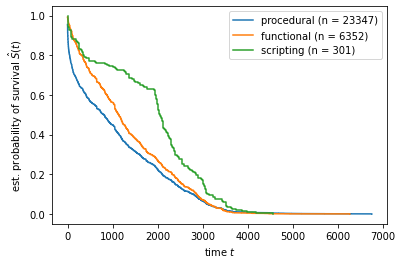

In [5]:
def f_map_pp(x):
    a = int(x['programming_paradigm'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    if a == 3:
        return 3
    else:
        return 0

condition_names_pp = {1 : 'procedural', 2: 'scripting', 3:'functional', 0: 'other'}

S1, S2 = apply_stats_for_each_value(df[:30000], f_map_pp, condition_names_pp)
display(S1), display(S2)

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,30000.0,1.0,892.0,2.443836,-0.02,-0.03,-0.02


,count,median,min,max,std,mean
agg,,,,,,
static,13977,822.0,0,6756,1101.141601,1104.137369
dynamic,16023,961.0,0,6269,1062.035049,1174.050490


(None, None)

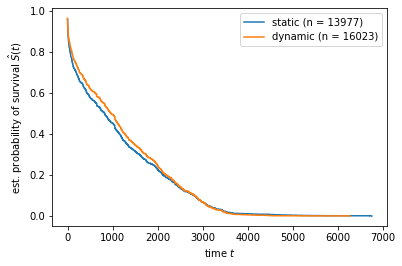

In [6]:
def f_map_cc(x):
    a = int(x['compilation_class'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names_cc = {1 : 'static', 2: 'dynamic', 0: 'other'}

S1, S2 = apply_stats_for_each_value(df[:30000], f_map_cc, condition_names_cc)
display(S1), display(S2)

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,30000.0,1.0,892.0,2.443836,0.03,0.03,0.03


,count,median,min,max,std,mean
agg,,,,,,
strong,16386,961.0,0,6269,1030.072554,1158.471256
weak,13614,818.0,0,6756,1138.933037,1121.024607


(None, None)

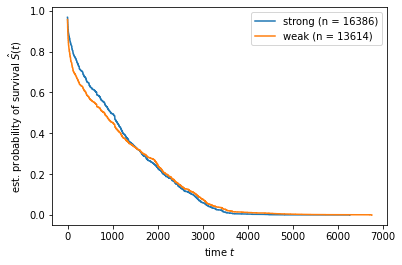

In [7]:
def f_map_tc(x):
    a = int(x['type_class'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names_tc = {1 : 'strong', 2: 'weak', 0: 'other'}

S1, S2 = apply_stats_for_each_value(df[:30000], f_map_tc, condition_names_tc)
display(S1), display(S2)

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,30000.0,1.0,892.0,2.443836,0.05,0.04,0.05


,count,median,min,max,std,mean
agg,,,,,,
managed,24569,956.0,0,6756,1070.345979,1174.959461
non managed,5431,532.0,0,6756,1115.423630,990.012889


(None, None)

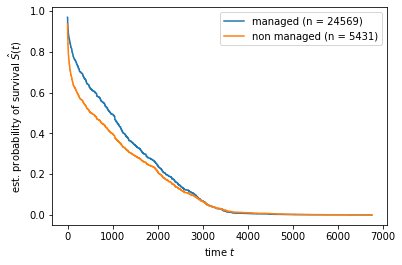

In [8]:
def f_map_mm(x):
    a = int(x['memory_model'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names_mm = {1 : 'managed', 2: 'non managed', 0: 'other'}

S1, S2 = apply_stats_for_each_value(df[:30000], f_map_mm, condition_names_mm)
display(S1), display(S2)